## Table of Contents

- [Project Description](#in)
- [1: Loading the dataset and EDA](#1)
- [2: Preprocessing](#2)
- [3: Model building](#3)
- [4: Hyperparameter optimization](#4)
- [5: Test results](#5)

In [8]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer

# train test split and cross validation
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

In [2]:
from sklearn.impute import SimpleImputer

## Project Description <a name="in"></a>
<hr>

In this lab, we'll focus on two things:
1. Working with text data
2. Hyperparameter optimization

This is a text classification project. A SMS spam filtering system is developed using Kaggle's [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset). I will use `CountVectorizer` to encode text messages and `SVC` for classification.

## 1: Loading the dataset and EDA <a name="1"></a>
<hr>

Download the data CSV in the data folder. **Sorry for the offensive language in some text messages; it's the reality of such platforms 😔.** 

In [3]:
# Loading dataset
sms_df = pd.read_csv("data/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [8]:
sms_df.shape

(5572, 2)

### 1.1 Data splitting 

1. Split `sms_df` into train (80%) and test splits (20%). 
2. Examine the first few rows of the train portion. 

In [4]:
train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends ...
1283,ham,Yes i thought so. Thanks.
2327,spam,URGENT! Your mobile number *************** WON...
1103,ham,Aiyah sorry lor... I watch tv watch until i fo...


### 1.2 Simple EDA 

In case of text data the usual EDA is not applicable. I will carry out some simple EDA to get a sense of the data.  

1. What's the label distribution in the target column? 
2. What's the average length in characters of text messages? Show the shortest and longest text messages. 
3. Would you classify `sms` column as a categorical column? Does it make sense to carry out one-hot encoding on this column? Why or why not? 

In [6]:
### Exploring label distribution in the target column
# train_df["target"].unique()
train_df["target"].value_counts()

ham     3843
spam     614
Name: target, dtype: int64

In [5]:
### Exploring average length of text messages
sorted_df = train_df.reindex(train_df.sms.str.len().sort_values().index)
print(
    "Average length of text messages in number of characters: %0.3f\n"
    % (train_df.sms.str.len().mean())
)

### Show samples
print("Shortest sms: %s\n" % (sorted_df.iloc[0]["sms"]))
print("Longest sms: %s\n" % (sorted_df.iloc[-1]["sms"]))

Average length of text messages in number of characters: 80.284

Shortest sms: Ok

Longest sms: The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarassed that there's underwear and bras strewn on the bed, pillows on the floor, that's something else. You used to be good about at least making the bed.



- There are no fixed categories in the `sms` column. It makes more sense to encode this free text column with `CountVectorizer` than carrying out OHE (since each value is going to be different and fairly unique).

### 1.3 Word clouds

- Create one word cloud for text messages with `spam` target.

In [6]:
spam_messages = " ".join(train_df[train_df["target"] == "spam"]["sms"].tolist())
ham_messages = " ".join(train_df[train_df["target"] == "ham"]["sms"].tolist())

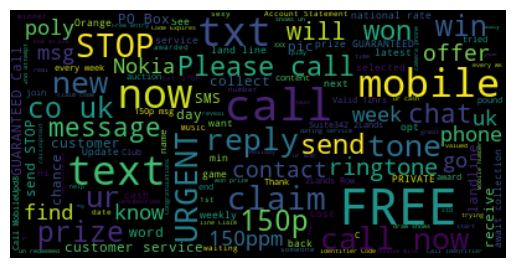

In [9]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=40).generate(spam_messages)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

- Create another word cloud for text messages with `non-spam` targets.

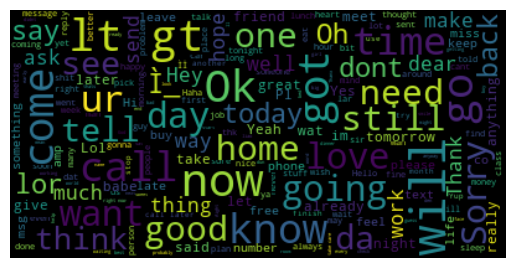

In [10]:
wordcloud = WordCloud(max_font_size=40).generate(ham_messages)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 2: Preprocessing <a name="2"></a>
<hr>

I will be encoding the text data using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and exploring different options of `CountVectorizer`.

### 2.1 `CountVectorizer` with default parameters

Transform the training data using `CountVectorizer` with default parameters. 

In [13]:
vec = CountVectorizer()
vec.fit(X_train, y_train)
transformed_X_train = vec.transform(X_train)
print("%d total number of features " % (len(vec.vocabulary_)))

7682 total number of features 


- 7682 features are created. Each feature represents roughly a unique word occurring in the corpus and each feature value represents how many times the word occurs in the given text message. 

### 2.2 `CountVectorizer` transformer with `binary=True`

Transform the training data using `CountVectorizer` with `binary=True`. 

In [14]:
vec = CountVectorizer(binary=True)
vec.fit(X_train, y_train)
transformed_X_train = vec.transform(X_train)
print("%d total number of features " % (len(vec.vocabulary_)))

7682 total number of features 


- Very often this representation works better in practice than the default one.
- Note: With this option, each feature represents roughly a unique word occurring in the corpus and each feature value represents whether the word occurs or not (1 for existing, 0 for not existing) in the given text message instead of counting the number of occurence. This option does not affect the number of unique features.

### 2.3 `max_features` hyperparameter of `CountVectorizer` 

1. Now pass `max_features=10` to `CountVectorizer` and transform the training data again. 
2. How many features have been created to represent each text message now?
3. Are we likely to overfit or underfit with less number of features? 
4. What would happen if you encounter a word in test data that's not present in `max_features` of the training data? 

In [17]:
vec = CountVectorizer(max_features=10)
vec.fit(X_train, y_train)
transformed_X_train = vec.transform(X_train)
print("%d total number of features " % (len(vec.vocabulary_)))

pd.DataFrame(transformed_X_train.toarray(), columns=sorted(vec.vocabulary_), index=X_train)

10 total number of features 


,and,for,in,is,it,me,my,the,to,you
sms,,,,,,,,,,
It took Mr owl 3 licks,0,0,0,0,1,0,0,0,0,0
Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so you see how I'm hesitant,2,0,0,0,0,2,1,0,1,1
Yes i thought so. Thanks.,0,0,0,0,0,0,0,0,0,0
"URGENT! Your mobile number *************** WON a å£2000 Bonus Caller prize on 10/06/03! This is the 2nd attempt to reach you! Call 09066368753 ASAP! Box 97N7QP, 150ppm",0,0,0,1,0,0,0,1,1,1
Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
I accidentally brought em home in the box,0,0,1,0,0,0,0,1,0,0
"Aight I've been set free, think you could text me blake's address? It occurs to me I'm not quite as sure what I'm doing as I thought I was",0,0,0,0,1,2,0,0,1,1
Is it ok if I stay the night here? Xavier has a sleeping bag and I'm getting tired,1,0,0,1,1,0,0,1,0,0


- 10 features have been created to represent each message now.
- We are likely to underfit with less number of features. When we encounter a word in test data that's not present in `max_features`, the word will be just ignored since it only focuses on the 10 main features.

## 3: Model building <a name="3"></a>
<hr>

## 3.1 `DummyClassifier`

1. Build a pipeline for feature extraction using `CountVectorizer` with `binary=True` and `DummyClassifier`.
2. Report mean cross-validation scores of the pipeline. 

In [18]:
# Build a DummyClassifier pipeline
dummy_pipe = make_pipeline(CountVectorizer(binary=True), DummyClassifier(strategy="most_frequent"))
scores = cross_validate(dummy_pipe, X_train, y_train, return_train_score=True)

# Report mean cross-validation scores
pd.DataFrame(scores).mean()

fit_time       0.196197
score_time     0.046886
test_score     0.862239
train_score    0.862239
dtype: float64

### 3.2 `SVC` with default parameters

Now build a pipeline for feature extraction using `CountVectorizer` with `binary=True` and `SVC` with default hyperparameters. Compare it to `DummyClassifier`.

In [19]:
# Build a SVC pipeline
svc_pipe_binary = make_pipeline(CountVectorizer(binary=True), SVC())
scores = cross_validate(svc_pipe_binary, X_train, y_train, return_train_score=True)

# Report mean scores
pd.DataFrame(scores).mean()

fit_time       0.750368
score_time     0.154059
test_score     0.979133
train_score    0.995961
dtype: float64

### Report

The `SVC` with default parameters is giving us better scores than the `DummyClassifier`.

## 4: Hyperparameter optimization <a name="4"></a>
<hr>

Use the `scikit-learn` [built-in methods](https://scikit-learn.org/stable/modules/grid_search.html) to pick the hyperparameters with lowest validation (or cross-validation) error. In this project, I will focus on two such methods:

1. [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 
2. [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

### 4.1 Optimizing `gamma` for RBF SVM 

Carry out hyperparameter search over `gamma` by sweeping the hyperparameter through the values $10^{-3}, \ldots, 10^{-1}, 1, \ldots, 10^{3}$ using [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and 10-fold cross-validation.

A few tips about `GridSearchCV`: 
- The `parameter grid` is defined for `gamma` which you can pass to your `GridSearchCV`. Note the syntax `clf__gamma`. There are two steps in the pipeline and you can access the parameters of these steps using __ to go deeper. So `clf__gamma` means `gamma` of `clf` step of the pipeline. 
- Setting `n_jobs=-1` should speed it up (if you have a multi-core processor).
- Similar to `cross_validate` you can pass `return_train_score=True` to your `GridSearchCV` object.
- After running `fit` on the `GridSearchCV` object, 
    - you can access best hyperparameter values with `grid.best_params_` and best scores with `grid.best_score_` if `grid' is your `GridSearchCV` object.
    - you can access mean train and cross-validation scores for all hyperparameter values via `grid.cv_results_` dictionary. 

In [20]:
# Build a plotting support function
def plot_train_cv(param_vals, train_scores, cv_scores, xlabel, ylabel="accuracy"):
    plt.semilogx(param_vals, train_scores, label="train")
    plt.semilogx(param_vals, cv_scores, label="valid")
    plt.legend()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [21]:
param_grid = {"svc__gamma": 10.0 ** np.arange(-3, 3)}

In [22]:
print(
    "We are carrying out %d 10-fold cross-validation experiments"
    % (np.prod(list(map(len, param_grid.values()))))
)

gamma_search = GridSearchCV(
    svc_pipe_binary, param_grid, n_jobs=-1, cv=10, return_train_score=True
)
gamma_search.fit(X_train, y_train)
print("Best hyperparameter values: ", gamma_search.best_params_)
print("Best score: %0.3f" % (gamma_search.best_score_))

We are carrying out 6 10-fold cross-validation experiments
Best hyperparameter values:  {'svc__gamma': 0.01}
Best score: 0.977


In [24]:
# Display the scores with different parameters
pd.DataFrame(gamma_search.cv_results_)[
    [
        "param_svc__gamma",
        "mean_train_score",
        "mean_test_score",
        "mean_fit_time",
        "mean_score_time",
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index()

,param_svc__gamma,mean_train_score,mean_test_score,mean_fit_time,mean_score_time
rank_test_score,,,,,
1,0.01,0.984494,0.976666,0.887802,0.080396
2,0.1,0.997333,0.975544,1.577198,0.146099
3,0.001,0.899060,0.893875,1.236301,0.120200
4,1.0,0.999776,0.893427,3.131101,0.302299
5,10.0,1.000000,0.892754,3.134198,0.303101
5,100.0,1.000000,0.892754,4.257295,0.399699


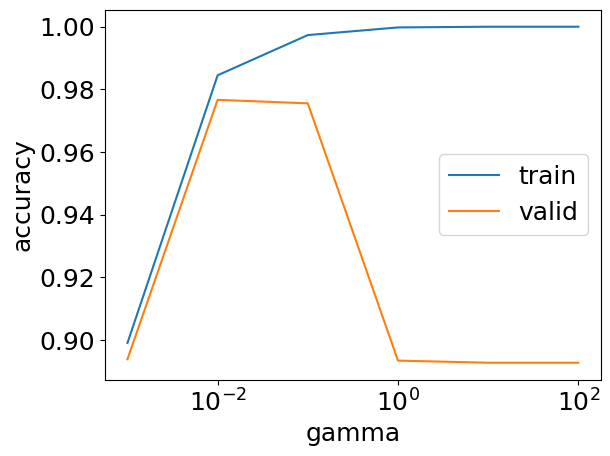

In [26]:
# Plot the training
train_scores = gamma_search.cv_results_["mean_train_score"]
cv_scores = gamma_search.cv_results_["mean_test_score"]

plot_train_cv(param_grid["svc__gamma"], train_scores, cv_scores, xlabel="gamma")

### Report

- We see that for larger values of `gamma` the training score goes up but the gap between the training score and the cross-validation score is increasing.
- We don't see a big difference after hyperparameter optimization of `gamma`. The mean train and test scores for `gamma`=0.01 and 0.1 are quite close to the scores in 3.2. In fact, mean validation score with the default `gammma` is slightly better. The default value of `gamma` is `scale` which seems to be working pretty well in this case.  

### 4.2 Jointly optimizing `C` and `gamma`

Expand our search to cover the `C` hyperparameter in addition to `gamma`, sweeping the hyperparameter through values $10^{-3}, 10^{-2}, \ldots, 10^{3}$. Use the same `gamma` values from 4.1. 
2. Did you get the same best `gamma` value that you got when optimizing `gamma` only? Why or why not?  

In [27]:
param_grid = {
    "svc__gamma": 10.0 ** np.arange(-3, 3),
    "svc__C": 10.0 ** np.arange(-3, 3),
}
print(
    "We are carrying out %d 10-fold cross-validation experiments"
    % (np.prod(list(map(len, param_grid.values()))))
)

gamma_search = GridSearchCV(
    svc_pipe_binary, param_grid, n_jobs=-1, return_train_score=True
)
gamma_search.fit(X_train, y_train)
print("Best hyperparameter values: ", gamma_search.best_params_)
print("Best score: %0.3f" % (gamma_search.best_score_))

We are carrying out 36 10-fold cross-validation experiments
Best hyperparameter values:  {'svc__C': 100.0, 'svc__gamma': 0.001}
Best score: 0.984


### Report

- We got a different value of `gamma` from the result in 4.1, which makes sense. A joint search over a $n$-dimensional parameter space may yield a different optimum than searching over any of those parameters individually. On a side note, we are trying more models now, so optimization bias can increase. 

### 4.3 Optimizing `C`, `gamma`, and `max_features` jointly with `RandomizedSearchCV`

Jointly optimize `C` and `gamma` hyperparameter of SVC RBF, and `max_features` hyperparameter of `CountVectorizer` using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [28]:
param_grid = {
    "svc__C": 10.0 ** np.arange(-3, 3),
    "svc__gamma": 10.0 ** np.arange(-3, 3),
    "countvectorizer__max_features": [10, 100, 1000, 8000],
}

In [29]:
random_search = RandomizedSearchCV(
    svc_pipe_binary,
    param_grid,
    n_iter=50,
    verbose=1,
    n_jobs=-1,
    random_state=123,
    return_train_score=True,
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(binary=True)),
                                             ('svc', SVC())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'countvectorizer__max_features': [10,
                                                                          100,
                                                                          1000,
                                                                          8000],
                                        'svc__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
                   random_state=123, return_train_score=True, verbose=1)

In [30]:
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_svc__C",
        "param_countvectorizer__max_features",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

Best hyperparameter values:  {'svc__gamma': 0.1, 'svc__C': 100.0, 'countvectorizer__max_features': 1000}
Best score: 0.984


,mean_train_score,mean_test_score,param_svc__C,param_countvectorizer__max_features,mean_fit_time
rank_test_score,,,,,
1,0.999551,0.984293,100.0,1000,1.126201
2,1.000000,0.984068,100.0,8000,0.681398
3,0.984070,0.977113,10.0,8000,0.634999
4,0.979470,0.975317,1.0,1000,0.530398
5,0.997252,0.974645,1.0,8000,1.266401
6,0.994223,0.966795,10.0,100,0.410999
7,0.960399,0.956697,10.0,100,0.389800
8,0.996971,0.925508,10.0,100,1.360401
9,0.996971,0.918104,1.0,100,2.175998


### Report

- We don't see a big performance improvement after hyperparameter optimization with one more hyperparameter `max_features`. 
- It runs faster using `RandomizedSearchCV` compared to using `GridSearchCV`

### Takeaway: `GridSearchCV` vs `RandomizedSearchCV`

In addition to `GridSearchCV` there are other approaches like `RandomizedSearchCV`, which, as its name implies, tries random hyperparameter configurations instead of performing an exhaustive grid search.

- `GridSearchCV` can be slow and computationally intensive when the search space is large, as it tries out every possible combination of the values and measures the model performance for that configuration. Also, when there are some unimportant hyperparameters in the grid, it wastes many searches while systematically sweeping through this unimportant hyperparameter.
- `RandomizedSearchCV` approach is preferable in such scenarios, as it tries out a given number of trails from the search space at random. Because of its random nature, it explores more parts of the search space and is less likely to waste searches caused by systematically sweeping over unimportant hyperparameters. 

### 4.4 Future Work: More sophisticated hyperparameter tuning

There are all sorts of software packages that make hyperparameter tuning with `scikit-learn` even more automated. For example:

- [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn)
- [auto-sklearn](https://github.com/automl/auto-sklearn)
- [SigOptSearchCV](https://sigopt.com/docs/overview/scikit_learn)

Being more adventurous, we can also try a package that isn't tied to `scikit-learn`. There are many options to play around:

- [TPOT](https://github.com/rhiever/tpot)
- [hyperopt](https://github.com/hyperopt/hyperopt)
- [hyperband](https://github.com/zygmuntz/hyperband)
- [SMAC](http://www.cs.ubc.ca/labs/beta/Projects/SMAC/)
- [MOE](https://github.com/Yelp/MOE)
- [pybo](https://github.com/mwhoffman/pybo)
- [spearmint](https://github.com/HIPS/Spearmint)
- [BayesOpt](https://github.com/rmcantin/bayesopt)

In other news, the recently announced [Amazon SageMaker](https://aws.amazon.com/sagemaker/) is also supposed to do hyperparameter optimization for you (among many other things it does).

## 5: Test results <a name="5"></a>
<hr>

Having done extensive hyperparameter search, let's try our best model on the test split. 

### 5.1 Report test scores

1. Fit the `best_estimator_` from the `RandomizedSearchCV` in 4.3 on `X_train` and `y_train` 
2. Score the fit model on `X_test` and `y_test`. 

In [31]:
best_model_pipe = random_search.best_estimator_
best_model_pipe.fit(X_train, y_train)

print("Grid Search best model score: %0.3f" % (random_search.best_score_))
print("Train score: %0.3f" % (best_model_pipe.score(X_train, y_train)))

# Report test score
print("Test score: %0.3f" % (best_model_pipe.score(X_test, y_test)))

Grid Search best model score: 0.984
Train score: 1.000
Test score: 0.983


### Report

- The test scores are consistent with the best score of RandomizedSearchCV. So our cross-validation results seem representative of the test data and the model doesn't seem to overfit.
- Note that this doesn't mean that we have a close to perfect and a reliable system for spam identification. Our dataset is rather small and the `most_frequent` baseline for the dataset is pretty high. More rigorous evaluation, probably on some data in the wild, would give us a better picture.